# Chapter 1 and Chapter 2

### Audio processing

- For a dataframe of audio data:
    - each column is a sample
    - each row is a point in time/amplitude of a sample
- So when using for machine learning,
    - each column name is a label
    - each column series should be converted to a row of features (eg: mean, max, std, tempo mean, beat mean, stft mean etc)
    - you can also use percentile to get value at specific percentile and use them as features
    - NEVER SHUFFLE (time series like index will be lost)
    - Missing data should be interpolated for time series
    - Rolling window can be used along with stat functions as well for generating new features


```
import librosa as lr
from glob import glob

# Function to extract audio features from a single file
def extract_features(file_path):
    audio, sfreq = lr.load(file_path) # load an audio file into amplitude data array and number of sample per second
    time = np.arange(0, len(audio)) / sfreq # Create time array
    # Plot : Auditory envelope (smoothing signal) for visualization
    audio_rectified = audio.apply(np.abs)
    audio_envelope = audio_rectified.rolling(50).mean() 
    fig, ax = plt.subplots()
    ax.plot(time, audio) # time on X axis and amplitude on Y-axis
    ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')
    plt.show()
    #### FEATURES ####
    mfccs = np.mean(lr.feature.mfcc(y=audio, sr=sfreq, n_mfcc=13), axis=1)
    chroma = np.mean(lr.feature.chroma_stft(y=audio, sr=sfreq), axis=1)
    spectral_contrast = np.mean(lr.feature.spectral_contrast(y=audio, sr=sfreq), axis=1)
    tonnetz = np.mean(lr.feature.tonnetz(y=audio, sr=sfreq), axis=1)
    tempogram = np.mean(lr.feature.tempogram(y=audio, sr=sfreq), axis=1)
    # Compute spectrogram (STFT) : THIS IS A TIME SERIES OF OSCILLATION
    spectrogram = lr.stft(y=audio)
    spec_db = np.mean(lr.amplitude_to_db(np.abs(spectrogram)), axis=1) # Convert to decibel for easier representation
    spectral_centroid = np.mean(lr.feature.spectral_centroid(y=audio, sr=sfreq))
    spectral_bandwidth = np.mean(lr.feature.spectral_bandwidth(y=audio, sr=sfreq))
    features = np.concatenate([mfccs, chroma, spectral_contrast, tonnetz, tempogram, spec_db,
                               [spectral_centroid, spectral_bandwidth]])
    return features

# Directory containing audio files
audio_files = glob('dataset/*.wav')

# Create feature matrix X
X = []
for file_path in audio_files:
    features = extract_features(file_path)
    X.append(features)

X = np.array(X)

```

# Chapter 3

- Find missing data through visualization : 
    1. Missing data should be interpolated for time series
    2. Rolling window can be used along with stat functions as well

```
from functools import partial

def multiply(a, b):
    return a * b

double = partial(multiply, b=2)

result = double(10)
print(result)
```

# Chapter 4

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("dataset/prices.csv", parse_dates=["date"], index_col="date")
YHOO = df[df["symbol"].isin(["YHOO"])].drop(["symbol","volume"], axis=1)
YHOO= YHOO.div(YHOO.iloc[0])
YHOO.head()

,close
date,
2010-01-04,1.000000
2010-01-05,1.007602
2010-01-06,1.004094
2010-01-07,0.976608
2010-01-08,0.976608


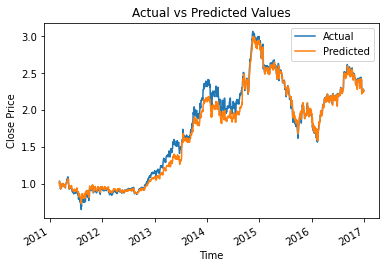

In [27]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import matplotlib.pyplot as plt

df = YHOO  # Assuming YHOO is your DataFrame containing stock data
num_lags = 3  # Adjust this according to your needs
for i in range(1, num_lags + 1): # Creating features
    df[f'lag_{i}'] = df['close'].shift(i)
df.dropna(inplace=True) # Drop rows with NaN values resulting from the shift operation
X = df.drop(columns=['close'])  # Features (lagged versions)
y = df['close']  # Target variable

actual_values = []
predicted_values = []
tscv = TimeSeriesSplit(n_splits=5, max_train_size=30) # window = 30
model = LinearRegression()

# Train the model and make predictions
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    actual_values.extend(y_test) # Append actual and predicted values to the lists (Use extend to append the values instead of whole list)
    predicted_values.extend(y_pred)


result = pd.DataFrame({'Actual': actual_values, 'Predicted': predicted_values}, index=df.index[-len(predicted_values):])
result.plot()
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Values')
plt.show()
